#### TO DO
I want to cluster the 900+ unique APR DRG Description values 
#### WHY?
Because I think the model's learning will be affected by the large one hot encoding if I just leave it as is from now
#### HOW
I will vectorize each of the unique APR DRG Description values and then use KMeans clustering to group those vectors together hopefully reducing the large number of features
#### RESULT(hopefully)
Hopefully this will result in about 30-45 unique clusters that I can assign a particular diagnosis to and use this as my one hot vector. Maybe I can even use this grouping and the trained KMeans to perform feature selection along with my Gemini

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import re
import pandas as pd
import json

C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SPARCS_df = pd.read_csv('./Hospital_Inpatient_Discharges__SPARCS_De-Identified___Cost_Transparency__Beginning_2009_20250419.csv')

Lets first extract all the unique raw descriptions

In [3]:
# Prepare descriptions
descriptions_raw = SPARCS_df['APR DRG Description'].dropna().unique().tolist()

Now I will tokenize these descriptions using SentenceTransformer and all-MiniLM-L6-v2 and then perform clustering using KMeans to get 30 different clusters.

In [4]:
def cluster_descriptions(descriptions, n_clusters=30, model_name="all-MiniLM-L6-v2"):
    model = SentenceTransformer(model_name)
    embeddings = model.encode(descriptions, show_progress_bar=True)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    desc_to_cluster = dict(zip(descriptions, cluster_labels))
    return desc_to_cluster, embeddings, cluster_labels

# Run clustering (choose raw or cleaned)
desc_to_cluster, embeddings, cluster_labels = cluster_descriptions(descriptions_raw, n_clusters=30)

Batches: 100%|██████████| 30/30 [00:05<00:00,  5.64it/s]
C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Now lets see some of the example descriptions that are inside each cluster

In [5]:
def print_sample_clusters(desc_to_cluster, n_clusters=30, samples_per_cluster=5):
    for cluster_id in range(n_clusters):
        print(f"\nCluster {cluster_id}:")
        cluster_descs = [desc for desc, cid in desc_to_cluster.items() if cid == cluster_id]
        for desc in cluster_descs[:samples_per_cluster]:
            print(f"  - {desc}")
        print(f"Total descriptions: {len(cluster_descs)}")

print_sample_clusters(desc_to_cluster, n_clusters=30)


Cluster 0:
  - Other Back & Neck Disorders, Fractures & Injuries
  - Spinal Disorders & Injuries
  - Procedure W Diag Of Rehab, Aftercare Or Oth Contact W Health Service
  - Other Aftercare & Convalescence
  - Spinal Procedures
Total descriptions: 29

Cluster 1:
  - Neonate Birthwt 1500-1999G W Congenital/Perinatal Infection
  - Neonate Bwt 2000-2499G W Congenital/Perinatal Infection
  - Neonate Birthwt >2499G W Congenital/Perinatal Infection
  - Neonatal Aftercare
  - Neonate birthwt 1500-1999g w congenital/perinatal infection
Total descriptions: 12

Cluster 2:
  - Other Hepatobiliary, Pancreas & Abdominal Procedures
  - Hepatic Coma & Other Major Acute Liver Disorders
  - Malignancy Of Hepatobiliary System & Pancreas
  - Disorders Of Pancreas Except Malignancy
  - Pancreas Transplant
Total descriptions: 21

Cluster 3:
  - Allergic Reactions
  - Poisoning Of Medicinal Agents
  - Toxic Effects Of Non-Medicinal Substances
  - Signs, Symptoms & Other Factors Influencing Health Status
  

You can def tell the clustering did a fine job because when you read through these you can tell why some of the descriptions are clustered together for example Cluster 14 seems to be all about reproductive issues but there are still some clusters like Cluster 7 that seem to be a bit of a mix from a lot of different things. So lets see the keywords that maybe influence a description's membership in a cluster.

In [6]:
def print_cluster_keywords(desc_to_cluster, n_clusters=30, top_n=5):
    for cluster_id in range(n_clusters):
        cluster_descs = [desc for desc, cid in desc_to_cluster.items() if cid == cluster_id]
        words = ' '.join(cluster_descs).lower().split()
        top_words = [word for word, _ in Counter(words).most_common(top_n)]
        print(f"Cluster {cluster_id} keywords: {top_words}")

print_cluster_keywords(desc_to_cluster, n_clusters=30)


Cluster 0 keywords: ['&', 'other', 'back', 'spinal', 'of']
Cluster 1 keywords: ['neonate', 'infection', 'w', 'congenital/perinatal', 'birthwt']
Cluster 2 keywords: ['pancreas', 'liver', 'transplant', '&', 'other']
Cluster 3 keywords: ['&', 'other', 'poisoning', 'of', 'toxic']
Cluster 4 keywords: ['disorders', 'other', 'nervous', 'system', '&']
Cluster 5 keywords: ['neonate', 'major', 'procedure', 'w', 'birthwt']
Cluster 6 keywords: ['cardiac', 'heart', 'pacemaker', '&', 'or']
Cluster 7 keywords: ['procedures', '&', 'major', 'other', 'ear,']
Cluster 8 keywords: ['&', 'other', 'procedures', 'major', 'esophageal']
Cluster 9 keywords: ['other', 'neoplasms', 'for', 'leukemia', 'o.r.']
Cluster 10 keywords: ['skin', 'burns', 'graft', 'extensive', 'degree']
Cluster 11 keywords: ['procedures', '&', 'hernia', 'inguinal,', 'femoral']
Cluster 12 keywords: ['respiratory', 'pulmonary', '&', 'diagnoses', 'other']
Cluster 13 keywords: ['&', 'disorders', 'dependence', 'abuse', 'and']
Cluster 14 keyword

So clearly there is an issue because evn if you look at the very first cluster the most frequently occuring keyword in that cluster is the '&' sign which really doesnt add that much meaning to that cluster. So lets maybe try to remove stop words from being in consideration here before we perform vectorization and clustering.

In [7]:
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [8]:
# remove all stop words
def clean_and_tokenize(text):
    words = re.sub(r'[^a-zA-Z\s]', '', text).lower().split()
    return [word for word in words if word not in stop_words]

descriptions_cleaned = [' '.join(clean_and_tokenize(d)) for d in descriptions_raw]

In [9]:
# now lets perform clustering again but on this cleaned corpus clean_
clean_desc_to_cluster, clean_embeddings, clean_cluster_labels = cluster_descriptions(descriptions_cleaned, n_clusters=30)

Batches: 100%|██████████| 30/30 [00:02<00:00, 10.18it/s]
C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Lets again look at the smaples from each cluster and see if they are better 

In [10]:
print_sample_clusters(clean_desc_to_cluster, n_clusters=30)


Cluster 0:
  - cesarean delivery
  - ectopic pregnancy procedure
  - postpartum post abortion diagnoses wo procedure
  - preterm labor
  - false labor
Total descriptions: 10

Cluster 1:
  - heart failure
  - cardiac arrest
  - migraine headaches
  - acute myocardial infarction
  - acute subacute endocarditis
Total descriptions: 13

Cluster 2:
  - peripheral vascular disorders
  - hepatic coma major acute liver disorders
  - alcoholic liver disease
  - procedures endocrine nutritional metabolic disorders
  - diabetes
Total descriptions: 25

Cluster 3:
  - anal procedures
  - major thoracic abdominal vascular procedures
  - vascular procedures
  - major small large bowel procedures
  - small large bowel procedures
Total descriptions: 30

Cluster 4:
  - degenerative nervous system disorders exc mult sclerosis
  - major gastrointestinal peritoneal infections
  - osteomyelitis septic arthritis musculoskeletal infections
  - cellulitis bacterial skin infections
  - postop posttrauma device 

With this we can still see that each cluster really does seem to be grouped on some specific ideas but this time the pattern is even easier to see than before for example cluster 0, is about labor cluster 7 about new borns, cluster 8 about digestive system, 14 about reproduction, 21 about substance abuse, and 23 even seems to learn the specific functions of an ENT doctor. But there are still some that arent best grouped and I dont think there is a way to make these clusters better without increasing the number of clusters so lets try to find the best amount of clusters byt utilizing the Elbow Method and Silhouette Scores

In [11]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np


def plot_elbow_curve(embeddings, max_k=100):
    inertias = []
    silhouettes = []
    avg_cluster_sizes = []
    
    k_range = range(2, max_k+1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(embeddings)
        inertias.append(kmeans.inertia_)
        silhouettes.append(silhouette_score(embeddings, labels))
        unique, counts = np.unique(labels, return_counts=True)
        avg_cluster_size = np.mean(counts)
        avg_cluster_sizes.append(avg_cluster_size)

    return silhouettes, avg_cluster_sizes, inertias

sil_scores, avg_cluster_sizes, inertias = plot_elbow_curve(clean_embeddings)

C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

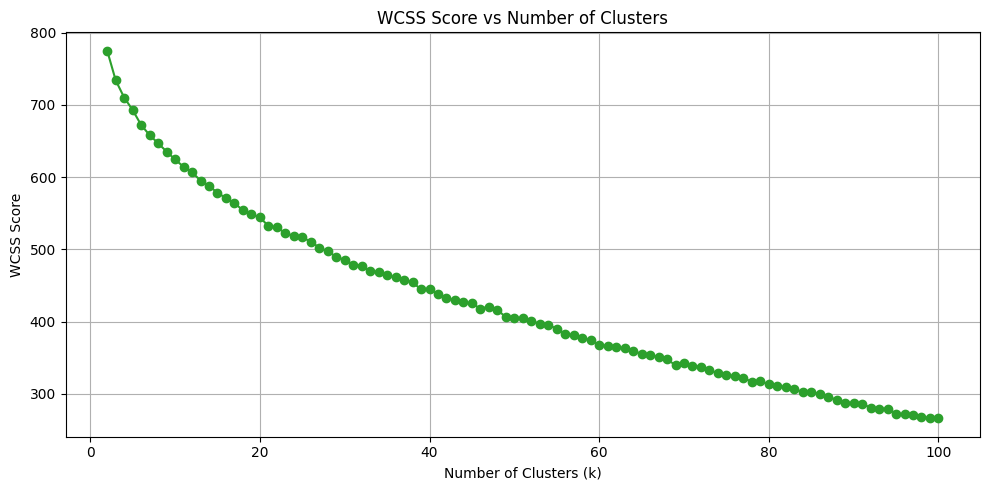

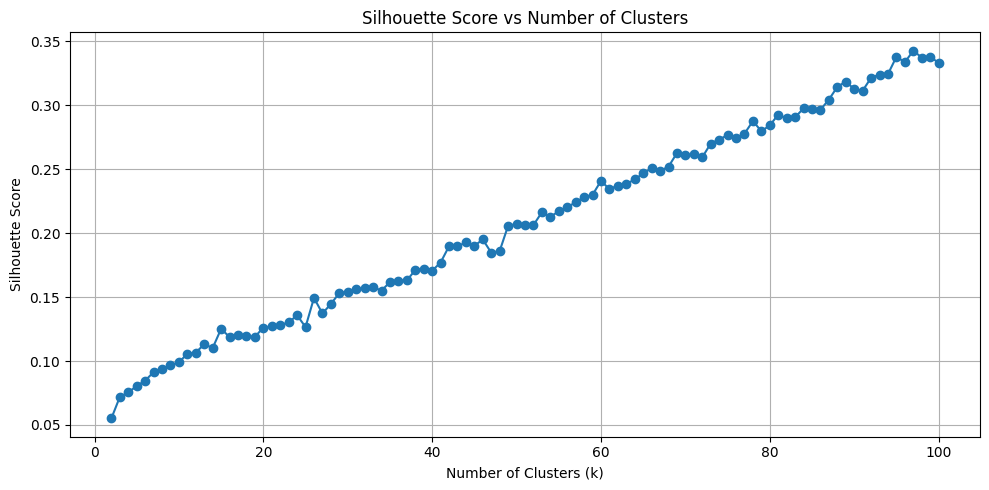

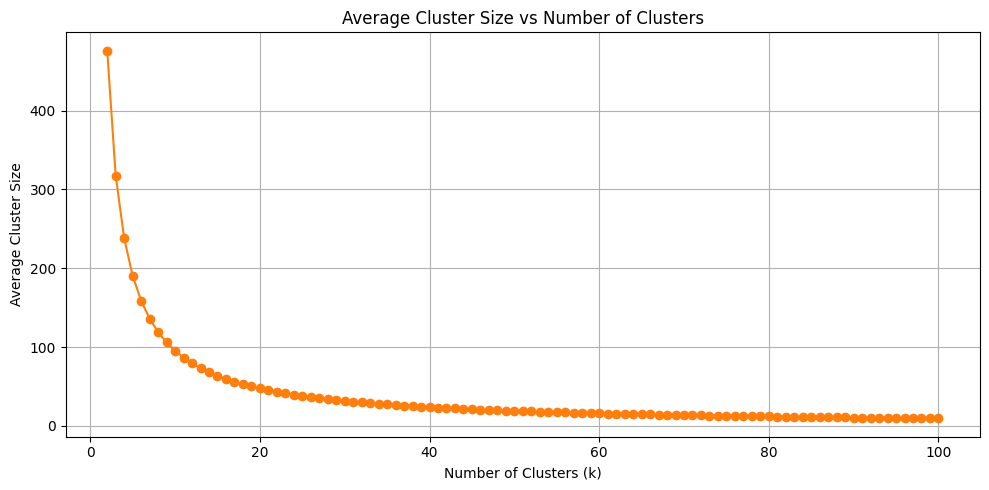

In [12]:
def plot_silhouette_and_cluster_size(k_min, k_max, sil_scores, avg_cluster_sizes, inertias):
    k_range = range(k_min, k_max + 1)
    idx_start = k_min - 2  # Adjust if sil_scores starts from k=2

    # Plot 1: WCSS Score
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, inertias[idx_start:k_max - 1], color='tab:green', marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('WCSS Score')
    plt.title('WCSS Score vs Number of Clusters')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 2: Silhouette Score
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, sil_scores[idx_start:k_max - 1], color='tab:blue', marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs Number of Clusters')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot 3: Average Cluster Size
    plt.figure(figsize=(10, 5))
    plt.plot(k_range, avg_cluster_sizes[idx_start:k_max - 1], color='tab:orange', marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Cluster Size')
    plt.title('Average Cluster Size vs Number of Clusters')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_silhouette_and_cluster_size(2, 100, sil_scores, avg_cluster_sizes, inertias)

So as expected WCSS and avg cluster size keep decreasing as we add more and more clusters to be available and honestly I cant see a clear elbow value here for the WCSS graph but from the graph we kind of see that the range between 20-40 clusters is the last time where WCSS decreases by a signifant amount cause after that the WCSS values are changing less and less as seen by how close those points are. I would say let's assume that our elbow value happens somewhere around k=35 because the change in WCSS from that point on is very little whilst still having about 30 descriptions per cluster which is quite manageable.

## Clustering

So lets now perform clustering with k=35 as asn assumed optimal num cluster

In [13]:
clean_desc_to_cluster, clean_embeddings, clean_cluster_labels = cluster_descriptions(descriptions_cleaned, n_clusters=35)

Batches: 100%|██████████| 30/30 [00:02<00:00, 10.03it/s]
C:\Users\patel\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [14]:
print_sample_clusters(clean_desc_to_cluster, n_clusters=35)


Cluster 0:
  - skin subcutaneous tissue related procedures
  - skin ulcers
  - contusion open wound trauma skin subcutaneous tissue
  - skin subcutaneous tissue breast disorders
Total descriptions: 4

Cluster 1:
  - major hematologicimmunologic diag exc sickle cell crisis coagul
  - allergic reactions
  - poisoning medicinal agents
  - toxic effects nonmedicinal substances
  - aftercare convalescence
Total descriptions: 12

Cluster 2:
  - osteomyelitis septic arthritis musculoskeletal infections
  - cellulitis bacterial skin infections
  - postop posttrauma device infections w procedure
  - postoperative posttraumatic device infections
  - cellulitis skin infections
Total descriptions: 6

Cluster 3:
  - neonate birth weight grams major procedure
  - neonate birth weight grams birth weight grams gestational age w
  - neonate birth weight grams without major procedure
  - neonate birth weight grams respiratory distress syndrome major
  - neonate birth weight grams without significant co

In [15]:
print_cluster_keywords(clean_desc_to_cluster, n_clusters=35)

Cluster 0 keywords: ['skin', 'subcutaneous', 'tissue', 'related', 'procedures']
Cluster 1 keywords: ['sickle', 'cell', 'crisis', 'major', 'poisoning']
Cluster 2 keywords: ['infections', 'device', 'cellulitis', 'skin', 'posttrauma']
Cluster 3 keywords: ['neonate', 'birth', 'weight', 'grams', 'major']
Cluster 4 keywords: ['disorders', 'sclerosis', 'nervous', 'system', 'electrolyte']
Cluster 5 keywords: ['cardiac', 'ami', 'procedures', 'percutaneous', 'coronary']
Cluster 6 keywords: ['neoplasms', 'procedures', 'malignancy', 'lymphatic', 'major']
Cluster 7 keywords: ['coma', 'hemorrhage', 'cva', 'precerebral', 'occlusion']
Cluster 8 keywords: ['diagnosis', 'principal', 'procedure', 'unrelated', 'extensive']
Cluster 9 keywords: ['procedures', 'major', 'bowel', 'small', 'large']
Cluster 10 keywords: ['neonate', 'g', 'w', 'bwt', 'birthwt']
Cluster 11 keywords: ['procedures', 'uterine', 'adnexa', 'radical', 'leiomyoma']
Cluster 12 keywords: ['disorders', 'depressive', 'mental', 'major', 'psych

Quite interesting here cause we do see some really good clusters. Looking at cluster0 it seems like its about skin diseases, cluster14 about reproductive systems, cluster17 retains that ENT doctor speciality. So these are very good results here from the clustering and we are finally able to just create a dictionary that can convert these groups into something specific using LLAMA

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

def get_cluster_keywords(descriptions, labels, top_n=5):
    vectorizer = TfidfVectorizer(max_features=1000)
    X = vectorizer.fit_transform(descriptions)
    feature_names = vectorizer.get_feature_names_out()

    cluster_keywords = {}
    for cluster in set(labels):
        cluster_indices = np.where(labels == cluster)[0]
        cluster_texts = [descriptions[i] for i in cluster_indices]
        cluster_X = vectorizer.transform(cluster_texts)
        mean_tfidf = np.asarray(cluster_X.mean(axis=0)).flatten()
        top_indices = mean_tfidf.argsort()[-top_n:][::-1]
        cluster_keywords[cluster] = [feature_names[i] for i in top_indices]

    return cluster_keywords


In [17]:
def generate_cluster_descriptions(cluster_keywords, generator, max_tokens=100):
    cluster_descriptions = {}
    for cluster_id, keywords in cluster_keywords.items():
        prompt = (
            f"Given the following keywords from a group of medical procedures: {', '.join(keywords)}, "
            "generate a concise sentence summarizing what type of medical procedures this cluster likely contains."
        )

        result = generator(prompt, max_new_tokens=max_tokens, do_sample=True, temperature=0.7)[0]["generated_text"]
        # Strip prompt to get just the sentence
        summary = result.split(prompt)[-1].strip()
        cluster_descriptions[cluster_id] = summary
    return cluster_descriptions


In [18]:
cluster_keywords = get_cluster_keywords(descriptions_cleaned, clean_cluster_labels, 5)
cluster_keywords

{0: ['skin', 'subcutaneous', 'tissue', 'ulcers', 'breast'],
 1: ['chemotherapy', 'leukemia', 'poisoning', 'acute', 'toxic'],
 2: ['infections', 'device', 'postoperative', 'cellulitis', 'posttraumatic'],
 3: ['weight', 'birth', 'grams', 'neonate', 'major'],
 4: ['disorders', 'endocrine', 'electrolyte', 'peripheral', 'nervous'],
 5: ['cardiac', 'ami', 'percutaneous', 'coronary', 'catheterization'],
 6: ['malignancy',
  'neoplasms',
  'lymphatichematopoieticother',
  'lymphatic',
  'digestive'],
 7: ['coma', 'hemorrhage', 'intracranial', 'cva', 'occlusion'],
 8: ['diagnosis', 'principal', 'unrelated', 'procedure', 'extensive'],
 9: ['procedures', 'mastectomy', 'bowel', 'small', 'large'],
 10: ['neonate', 'birthwt', 'bwt', 'major', 'resp'],
 11: ['uterine', 'adnexa', 'leiomyoma', 'procedures', 'radical'],
 12: ['disorders', 'mental', 'depressive', 'health', 'bipolar'],
 13: ['complications', 'treatment', 'procedure', 'reaction', 'malfunction'],
 14: ['reproductive', 'system', 'female', 'ma

In [24]:
SPARCS_df['APR DRG Description Clean'] = SPARCS_df['APR DRG Description'].fillna('').apply(
    lambda x: ' '.join(clean_and_tokenize(x))
)

# 2. Map each cleaned description to its cluster label
SPARCS_df['DRG_Cluster_Label'] = SPARCS_df['APR DRG Description Clean'].map(clean_desc_to_cluster)

# 3. Check for any unmapped descriptions
SPARCS_df['DRG_Cluster_Label'].isna().sum()

0

## Save our work

In [28]:
SPARCS_df.to_csv('./Hospital_Inpatient_Discharges__SPARCS_De-Identified___Cost_Transparency__Beginning_2009_20250419.csv')
serializable_dict = {k: int(v) for k, v in clean_desc_to_cluster.items()}

with open("./clean_desc_to_cluster.json", "w") as file:
    json.dump(serializable_dict, file, indent=4)